In [3]:
import os
import shutil
import vcf
import re
import gzip
import pandas as pd
#import yaml
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import numpy as np
#from IPython.display import Image
#from Bio import SeqIO
from scipy.interpolate import interp1d


#import rpy2.ipython


#%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

# Linkage Disequilibrium

In [ ]:
if not os.path.isdir("results/ld"):
    os.mkdir("results/ld")

Read in population assignment and create (new) list files

In [4]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)

In [5]:
for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)
    
for sample in pop_assign:
   
    pop=pop_assign[sample]
    list_file="results/ld/" + pop + ".list"
    with open(list_file, 'a') as filehandle:
        filehandle.write("{}\n".format(sample))

## Calculate R2 with VCFtools and Plink

In [237]:
in_vcf="results/variant_filtration/smv7_ex_autosomes.vcf"

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)
    in_list = "results/ld/{}.list".format(pop)
    
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        out_vcf = "results/ld/smv7_ex_autosomes_{}_{}.vcf".format(pop, chrom)
        
        #get ld chrom vcf
        vcf_cmd="vcftools --vcf {} --mac 1 --chr {} --keep {} --recode --recode-INFO-all --stdout >{}".format(in_vcf, chrom, in_list, out_vcf)
        !{vcf_cmd}

        #convert vcf to plink
        plink_prefix="results/ld/smv7_ex_autosomes_{}_{}".format(pop, chrom)
        plink_cmd="plink --threads 6 --vcf {} --out {} --double-id --recode12 --allow-extra-chr".format(out_vcf, plink_prefix)
        !{plink_cmd}  
        
        #calculate R2 between all snps on a chr
        plink_cmd="plink --threads 6 --r2 --file {} --out {} --double-id --allow-extra-chr --ld-window-r2 0.0 --ld-window 1000000 --ld-window-kb 1000".format(plink_prefix, plink_prefix)
        !{plink_cmd}


senegal
PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_senegal_SM_V7_1.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_senegal_SM_V7_1
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_senegal_SM_V7_1.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.bed +
results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.bim +
results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.fam written.
9381 variants loaded from .bim file.
25 people (0 males, 0 females, 25 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_senegal_SM_V7_1.nosex
.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filte

Make new files that contain all R2 info from Plink, but also add distance between SNP-A and SNP-B. 

In [238]:
#create tables
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)
    
    in_list = "results/ld/{}.list".format(pop)
    
    #open the outfile that will contain ALL of the data (and add a header)
    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'w') as merged_all_out_file:
        #print header line
        header_line="chr_a\tbp_a\tsnp_a\tchr_b\tbp_b\tsnp_b\tr2\ta_b_dist\n"
        merged_all_out_file.write(header_line)
        
        #open each chrom specific ld file (and skip the header)
        for chrom in list(range(1, 8)):
            chrom="SM_V7_{}".format(chrom)
            plink_file="results/ld/smv7_ex_autosomes_{}_{}.ld".format(pop, chrom)

            with open(plink_file, 'r') as in_file:
                next(in_file)

                #for each r2 calc
                for entry in in_file:
                    entry=','.join(entry.split())
                    chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2 = entry.split(",")

                    #calculate the distance between the snps
                    a_b_dist = int(bp_b) - int(bp_a)
                    outline=[chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, str(a_b_dist), "\n"]
                    outline="\t".join(outline)

                    #and print to the ALL output file
                    merged_all_out_file.write(outline)

senegal
niger
brazil
tanzania


In [239]:
#clean up all of the unused files
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        for ext in ["ld", "map", "ped", "log", "nosex", "vcf"]:
            file_to_del="results/ld/smv7_ex_autosomes_{}_{}.{}".format(pop, chrom, ext)
            if os.path.exists(file_to_del):
                os.remove(file_to_del)

## Bin and Smooth mean R2 values (in R)

In [319]:
#read in plink R2 data and create a df to save

dists=defaultdict(lambda: list())
r2s=defaultdict(lambda: list())

for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)

    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'r') as in_file:
        #skip header line
        next(in_file)

        for entry in in_file:
            chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, a_b_dist = entry.rstrip().split("\t")
            r2s[pop].append(float(r2))
            dists[pop].append(int(a_b_dist))

#convert to np array
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    dists[pop]=np.array(dists[pop])
    r2s[pop]=np.array(r2s[pop])

    
#create bins for stat binning
bins=[]
bins=bins + list(range(1,10,1))
bins=bins + list(range(10,100,10))
bins=bins + list(range(100,1_000, 100))
bins=bins + list(range(1_000,10_000, 100))
bins=bins + list(range(10_000, 100_000, 1_000))
bins=bins + list(range(100_000, 1_000_000, 10_000))


#get mean values for each bin
n, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic='mean', bins=bins)
b, bin_edges, binnumber=stats.binned_statistic(dists["brazil"], r2s["brazil"], statistic='mean', bins=bins)
s, bin_edges, binnumber=stats.binned_statistic(dists["senegal"], r2s["senegal"], statistic='mean', bins=bins)
t, bin_edges, binnumber=stats.binned_statistic(dists["tanzania"], r2s["tanzania"], statistic='mean', bins=bins)

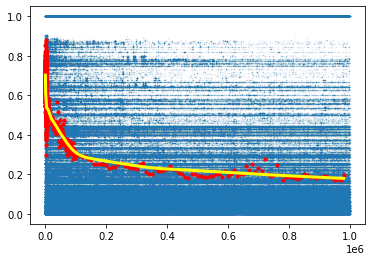

In [320]:
n, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic='mean', bins=bins)

plt.scatter(dists["niger"], r2s["niger"], s=0.1, alpha=0.1, label="raw data")
plt.scatter(df["distance_bin"], df["niger"], s=10, c="red", label="mean-binned")

    #smooth
l=lowess(df["niger"], df["distance_bin"], frac=0.05)
xl=l[:,0]
yl=l[:,1]
#plt.plot(xl, yl, label="Loess smoothed", linewidth=3, c='yellow')

l=lowess(df["niger"], df["distance_bin"], frac=0.5)
xl=l[:,0]
yl=l[:,1]
plt.plot(xl, yl, label="Loess smoothed", linewidth=3, c='yellow')

#plt.xlim(0,1_000)
    
#plt.legend()
plt.show()
plt.close()

In [324]:
unique, counts = np.unique(binnumber, return_counts=True)

np.array(bins)[counts<1000]

array([   1,    2,    3,    4,    5,    6,    7,    8,    9, 1800, 1900,
       2000, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100,
       3200, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500,
       6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600,
       7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700,
       8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800,
       9900])

In [312]:
bins

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600,
 5700,
 5800,
 5900,
 6000,
 6100,
 6200,
 6300,
 6400,
 6500,
 6600,
 6700,
 6800,
 6900,
 7000,
 7100,
 7200,
 7300,
 7400,
 7500,
 7600,
 7700,
 7800,
 7900,
 8000,
 8100,
 8200,
 8300,
 8400,
 8500,
 8600,
 8700,
 8800,
 8900,
 9000,
 9100,
 9200,
 9300,
 9400,
 9500,
 9600,
 9700,
 9800,
 9900,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 36000,
 37000,
 38000,
 39

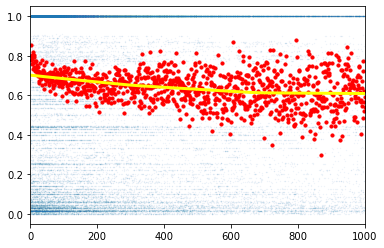

In [284]:
plt.scatter(dists["niger"], r2s["niger"], s=0.1, alpha=0.1, label="raw data")
plt.scatter(df["distance_bin"], df["niger"], s=10, c="red", label="mean-binned")

    #smooth
l=lowess(df["niger"], df["distance_bin"], frac=0.05)
xl=l[:,0]
yl=l[:,1]
#plt.plot(xl, yl, label="Loess smoothed", linewidth=3, c='yellow')

l=lowess(df["niger"], df["distance_bin"], frac=0.5)
xl=l[:,0]
yl=l[:,1]
plt.plot(xl, yl, label="Loess smoothed", linewidth=3, c='yellow')

plt.xlim(0,1_000)
    
#plt.legend()
plt.show()
plt.close()

In [269]:
df=pd.DataFrame(data=[bin_edges[:-1], n, b, s, t]).T
df.columns=["distance_bin", "niger", "brazil", "senegal", "tanzania"]
df.to_csv("results/ld/ld_dist_binned_smoothed_pybins.csv", sep=",")
df

,distance_bin,niger,brazil,senegal,tanzania
0,1.0,0.799512,0.747925,0.695876,0.450407
1,2.0,0.777853,0.690132,0.640989,0.333046
2,3.0,0.853547,0.740000,0.663142,0.359926
3,4.0,0.760119,0.663821,0.642140,0.311037
4,5.0,0.802618,0.724879,0.630532,0.301324
...,...,...,...,...,...
1263,940000.0,0.179358,0.033821,0.066332,0.029398
1264,950000.0,0.171549,0.033466,0.065192,0.028677
1265,960000.0,0.176167,0.035705,0.067460,0.029073
1266,970000.0,0.169764,0.034120,0.066552,0.028681


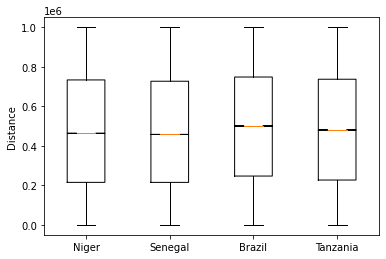

In [249]:
plt.boxplot([ dists["niger"][r2s["niger"]<0.2],
              dists["senegal"][r2s["senegal"]<0.2],
              dists["brazil"][r2s["brazil"]<0.2],
              dists["tanzania"][r2s["tanzania"]<0.2] ],
            showfliers=False, 
            notch=True,
            labels=["Niger", "Senegal", "Brazil", "Tanzania"])
plt.ylabel("Distance")
plt.show()

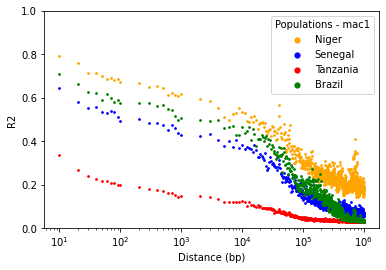

In [244]:
plt.scatter(df["distance_bin"], df["niger"],    s=3, c="orange",    label="Niger")
plt.scatter(df["distance_bin"], df["senegal"],  s=3, c="blue", label="Senegal")
plt.scatter(df["distance_bin"], df["tanzania"], s=3, c="red",  label="Tanzania")
plt.scatter(df["distance_bin"], df["brazil"],   s=3, c="green",   label="Brazil")
plt.xlabel("Distance (bp)")
plt.ylabel("R2")
plt.xscale('log')
plt.ylim(0,1)
#plt.xlim(-1_000,100_000)
plt.legend(title="Populations - mac1", markerscale=3)

#plt.savefig("results/ld/ld_decay_log_maf05.svg")
#plt.savefig("results/ld/ld_decay_log_maf05.png")

plt.show()
plt.close()

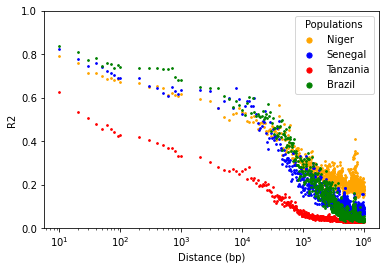

In [236]:
plt.scatter(df["distance_bin"], df["niger"],    s=3, c="orange",    label="Niger")
plt.scatter(df["distance_bin"], df["senegal"],  s=3, c="blue", label="Senegal")
plt.scatter(df["distance_bin"], df["tanzania"], s=3, c="red",  label="Tanzania")
plt.scatter(df["distance_bin"], df["brazil"],   s=3, c="green",   label="Brazil")
plt.xlabel("Distance (bp)")
plt.ylabel("R2")
plt.xscale('log')
plt.ylim(0,1)
#plt.xlim(-1_000,100_000)
plt.legend(title="Populations", markerscale=3)

plt.savefig("results/ld/ld_decay_log_maf05.svg")
plt.savefig("results/ld/ld_decay_log_maf05.png")

plt.show()
plt.close()

Tanzania: [14524.9654064]
Brazil: [27317.56982137]
Senegal: [25251.50050413]
Niger: [22249.15412671]


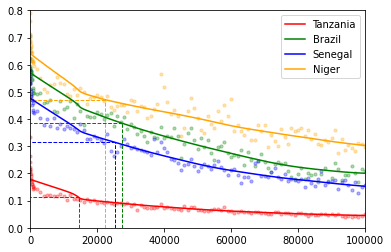

In [245]:
x=bin_edges[0:-1]

for y, label, color in [(t, "Tanzania", "red"), 
                 (b, "Brazil", "green"),
                 (s, "Senegal", "blue"),
                 (n, "Niger", "orange")]:

    #plot
    plt.scatter(x, y, s=10, alpha=0.3, c=color)
    
    #smooth
    l=lowess(y, x, frac=0.05)
    xl=l[:,0]
    yl=l[:,1]
    plt.plot(xl, yl, label=label, c=color)
    
    #get ld50
    decay = interp1d(yl, xl, bounds_error=False)
    
    #what point is Ld50 In 250kb
    #OVER A MB ld=yl[0] - ((yl[0]-yl[x==x[-1]])/2)
    ld=yl[0] - ((yl[0]-yl[x==100_000])/2)
    ld50=decay(ld)
    
    #add line to chart
    plt.vlines(ld50, 0, ld, colors=color, linestyle='dashed', linewidth=1)
    plt.hlines(ld, ld50, ld, colors=color, linestyle='dashed', linewidth=1)

    print("{}: {}".format(label, ld50))

plt.ylim(0,0.8)
plt.xlim(0,100_000)
plt.legend()
#plt.xscale('log')
plt.show()


In [ ]:
n, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic='mean', bins=bins)
b, bin_edges, binnumber=stats.binned_statistic(dists["brazil"], r2s["brazil"], statistic='mean', bins=bins)
s, bin_edges, binnumber=stats.binned_statistic(dists["senegal"], r2s["senegal"], statistic='mean', bins=bins)
t, bin_edges, binnumber=stats.binned_statistic(dists["tanzania"], r2s["tanzania"], statistic='mean', bins=bins)


dists=defaultdict(lambda: list())
r2s=defaultdict(lambda: list())

for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)

    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'r') as in_file:
        #skip header line
        next(in_file)

        for entry in in_file:
            chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, a_b_dist = entry.rstrip().split("\t")
            r2s[pop].append(float(r2))
            dists[pop].append(int(a_b_dist))

#convert to np array
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    dists[pop]=np.array(dists[pop])
    r2s[pop]=np.array(r2s[pop])
    

In [ ]:
%%R
#in R generate summary stats for bins and plot

library(fields)

#500bp bins for 1Mb
breaks <- c(seq( 0, 1000, 10), 
            seq(1100, 10000, 100), 
            seq(10500, 1e6, 500))

centers   <- vector()
means     <- vector()
pops      <- vector()
smootheds <- vector()

for (pop in c("senegal", "tanzania", "brazil", "niger")) {
#for (pop in c("senegal")) {

    print(pop)
    
    #read in lt r2 table from plink
    ld_table <- read.table(paste("results/ld/smv7_ex_autosomes_", pop, "_dist.tbl", sep=""), 
                           header=TRUE)
    
    #bin r2 values and calculate stats
    ld_binned <- stats.bin(ld_table$a_b_dist, ld_table$r2, breaks = breaks)
    
    #created regression line
    loessMod  <- loess(ld_binned$stats["mean",] ~ ld_binned$centers, span=0.50)
    smoothed  <- predict(loessMod)
    
    #append all data to vectors
    centers   <- append(centers, ld_binned$centers)
    means     <- append(means, ld_binned$stats["mean",])
    pops      <- append(pops, rep(pop, length(ld_binned$centers)))
    smootheds <- append(smootheds, smoothed)
}    

#build the dataframe and save to csv
r2_df <- data.frame(centers, means, pops, smootheds)
#write.csv(r2_df, file = paste("results/ld/ld_dist_binned_smoothed.csv", sep="") ,row.names=FALSE)
write.csv(r2_df, file = paste("results/ld/ld_dist_binned_smoothed_gradbins.csv", sep="") ,row.names=FALSE)

In [4]:
#confert to a proper table (with the far superior power of python)
#df = pd.read_csv ('results/ld/ld_dist_binned_smoothed.csv')
df = pd.read_csv ('results/ld/ld_dist_binned_smoothed_gradbins.csv')

df = df.pivot(index='pops', columns='centers', values='smootheds')
df = df.T

#csv_file = "results/ld/ld_dist_binned_smoothed_table.csv"
#df.to_csv(csv_file, index=False, header=True, mode='w')

In [5]:
df

pops,brazil,niger,senegal,tanzania
centers,,,,
5,0.491180,0.576913,0.417821,0.139612
15,0.491149,0.576882,0.417792,0.139601
25,0.491118,0.576852,0.417762,0.139590
35,0.491087,0.576821,0.417733,0.139580
45,0.491056,0.576791,0.417704,0.139569
...,...,...,...,...
997750,0.032699,0.172109,0.067075,0.029002
998250,0.032690,0.172026,0.067052,0.029003
998750,0.032681,0.171942,0.067029,0.029005


## Plot the results

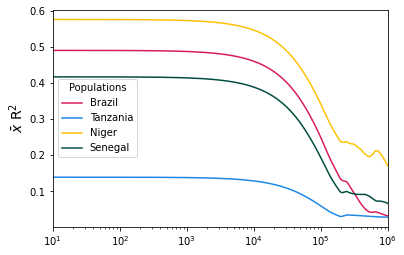

In [6]:
x=list(df.index)

plt.plot(x, df["brazil"],   c="#D81B60",   label="Brazil")
plt.plot(x, df["tanzania"], c="#1E88E5",  label="Tanzania")
plt.plot(x, df["niger"],    c="#FFC107", label="Niger")
plt.plot(x, df["senegal"],  c="#004D40", label="Senegal")

plt.xscale('log')
plt.xlim(10, 1e6)
#plt.xticks(ticks=[10, 100, 1000, 10000, 100000, 1000000], labels=["10e1", "10e2", "10e3", "10e4", "10e5", "10e6"])
#plt.xlabel("Distance between SNPs (Kb)", fontsize=14)

plt.ylabel(r'$\bar{x}$ R$^2$', fontsize=14)

plt.legend(title="Populations")

plt.savefig("results/ld/ld_decay_log.svg")
plt.savefig("results/ld/ld_decay_log.png")

plt.show()

In [8]:
dists=defaultdict(lambda: list())
r2s=defaultdict(lambda: list())

for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)

    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'r') as in_file:
        #skip header line
        next(in_file)

        for entry in in_file:
            chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, a_b_dist = entry.rstrip().split("\t")
            r2s[pop].append(float(r2))
            dists[pop].append(int(a_b_dist))

#convert to np array
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    dists[pop]=np.array(dists[pop])
    r2s[pop]=np.array(r2s[pop])

niger
senegal
brazil
tanzania


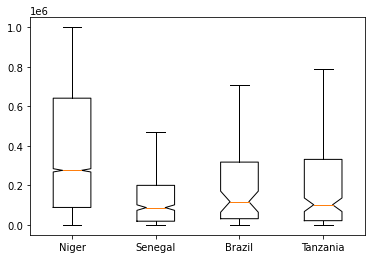

In [9]:
plt.boxplot([ dists["niger"][r2s["niger"]==0.5],
              dists["senegal"][r2s["senegal"]==0.5],
              dists["brazil"][r2s["brazil"]==0.5],
              dists["tanzania"][r2s["tanzania"]==0.5] ],
            showfliers=False, 
            notch=True,
            labels=["Niger", "Senegal", "Brazil", "Tanzania"])
plt.show()

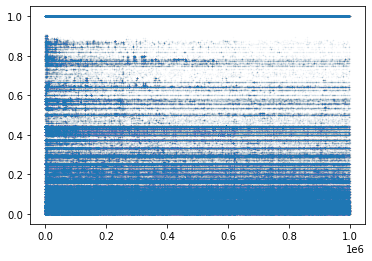

In [10]:
plt.scatter(dists["niger"], r2s["niger"], s=0.1, alpha=0.05)
plt.show()
plt.close()

In [12]:
#scipy.stats.binned_statistic(x, values, statistic='mean', bins=10, range=None)
bins=[]
bins=bins + list(range(0,100,10))
bins=bins + list(range(100,1_000, 100))
bins=bins + list(range(1_000, 1_000_000, 1_000))

In [13]:
# def perc_95(a):
#     x=np.percentile(a, 0.05)
#     return x

n, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic='mean', bins=bins)
b, bin_edges, binnumber=stats.binned_statistic(dists["brazil"], r2s["brazil"], statistic='mean', bins=bins)
s, bin_edges, binnumber=stats.binned_statistic(dists["senegal"], r2s["senegal"], statistic='mean', bins=bins)
t, bin_edges, binnumber=stats.binned_statistic(dists["tanzania"], r2s["tanzania"], statistic='mean', bins=bins)

#p, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic=perc_95, bins=bins)


Tanzania: [14524.9654064]
Brazil: [27317.56982137]
Senegal: [25251.50050413]
Niger: [22249.15412671]


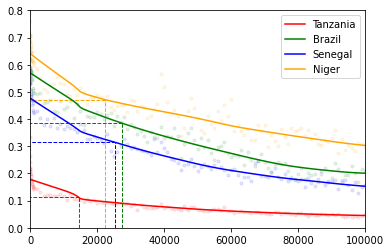

In [134]:
x=bin_edges[0:-1]

for y, label, color in [(t, "Tanzania", "red"), 
                 (b, "Brazil", "green"),
                 (s, "Senegal", "blue"),
                 (n, "Niger", "orange")]:

    #plot
    plt.scatter(x, y, s=10, alpha=0.1, c=color)
    
    #smooth
    l=lowess(y, x, frac=0.05)
    xl=l[:,0]
    yl=l[:,1]
    plt.plot(xl, yl, label=label, c=color)
    
    #get ld50
    decay = interp1d(yl, xl, bounds_error=False)
    
    #what point is Ld50 In 250kb
    #OVER A MB ld=yl[0] - ((yl[0]-yl[x==x[-1]])/2)
    ld=yl[0] - ((yl[0]-yl[x==100_000])/2)
    ld50=decay(ld)
    
    #add line to chart
    plt.vlines(ld50, 0, ld, colors=color, linestyle='dashed', linewidth=1)
    plt.hlines(ld, ld50, ld, colors=color, linestyle='dashed', linewidth=1)

    print("{}: {}".format(label, ld50))

plt.ylim(0,0.8)
plt.xlim(0,100_000)
plt.legend()
#plt.xscale('log')
plt.show()



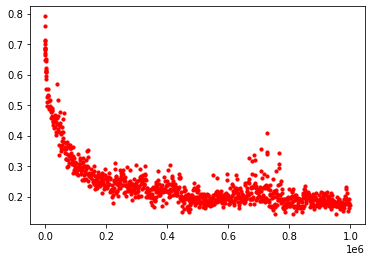

In [170]:
def perc_95(a):
    x=np.percentile(a, 0.80)
    return x

n, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic='mean', bins=bins)
# b, bin_edges, binnumber=stats.binned_statistic(dists["brazil"], r2s["brazil"], statistic='mean', bins=bins)
# s, bin_edges, binnumber=stats.binned_statistic(dists["senegal"], r2s["senegal"], statistic='mean', bins=bins)
# t, bin_edges, binnumber=stats.binned_statistic(dists["tanzania"], r2s["tanzania"], statistic='mean', bins=bins)

x=bin_edges[0:-1]
y=n
plt.scatter(x, y, s=10, alpha=1, c='red')
plt.show()
plt.close()

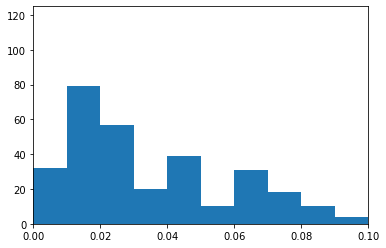

In [193]:
j=r2s["niger"][binnumber==1]
np.percentile(j, 0.95)
#j.mean()
plt.hist(j, bins=100)
plt.xlim(0, 0.1)
plt.ylim(0,125)
plt.show()
plt.close()

In [194]:
len(j)*0.05


124.2

In [106]:
decay = interp1d(yl, xl, bounds_error=False)

ld=yl[0] - ((yl[0]-yl[x==250000])/2)
ld50=decay(ld)
int(ld50)

32535

In [103]:
ld=yl[0] - ((yl[0]-yl[x==250000])/2)
ld

array([0.44436455])

In [104]:
f(ld)

array([32535.85598592])

In [20]:
from statsmodels.nonparametric.smoothers_lowess import lowess
l=lowess(y, xm)

# model = sklearn.linear_model.LinearRegression()
# model.fit(bin_edges[0:-1], n)

# plt.scatter(bin_edges[0:-1], n, s=10, alpha=1, c="red", label="Niger")
# plt.plot(bin_edges[0:-1],model.predict(bin_edges[0:-1],'k--'))
# plt.show()

In [28]:
xl=l[:,0]
yl=l[:,1]

In [16]:
x=bin_edges[0:-1]
y=n
# smoothedx, smoothedy = lowess(y, x, is_sorted=True, frac=0.025, it=0)


NameError: name 'lowess' is not defined

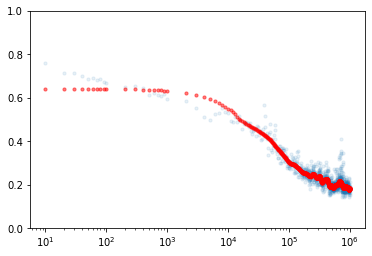

In [49]:
from statsmodels.nonparametric.smoothers_lowess import lowess
x=bin_edges[0:-1]
y=n

l=lowess(y, x, frac=0.05)

xl=l[:,0]
yl=l[:,1]

plt.scatter(bin_edges[0:-1], n, s=10, alpha=0.1)
plt.scatter(xl, yl, s=10, alpha=0.5, c="red")
plt.xscale('log')
plt.ylim(0,1)
plt.show()

In [135]:
import numpy as np
np.std(bin_means)

0.09404726178764827

In [ ]:
def ci95(data):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
    return m, m-h, m+h